# Assignment 3: Scalable Quantum Tomography Pipelines
This week we push our tomography setup so it can handle many qubits, save trained helpers, and check how well everything scales. Reuse the setup and datasets from earlier weeks. Keep the runs easy to repeat and measure speed properly.



---

## Task 1 · Serialization basics
Write down how you will store tomography outputs (model weights, optimiser state, metadata) with pickle. Mention when you would choose another format like HDF5.

**What to do**
- Add a short note in your report about the save strategy.
- Keep checkpoints inside `models/` and name them `model_<track>_<nqubits>.pkl`.
- Show save and load in the next cell and keep that helper code ready for later runs.

In [6]:
import pickle
from pathlib import Path

def save_pickle(obj, path):
    """TODO: Serialize `obj` to `path` using pickle."""
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, 'wb') as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    raise NotImplementedError("Implement serialization using pickle.dump.")

def load_pickle(path):
    """TODO: Deserialize an object from `path`."""
    path = Path(path)
    with open(path, 'rb') as f:
        return pickle.load(f)
    raise NotImplementedError("Implement deserialization using pickle.load.")

def demonstrate_serialization_roundtrip():
    """TODO: Create a quick round-trip save/load test and return the restored object."""
    test_obj = {
        'model_weights': {'layer1': [1.0, 2.0, 3.0]},
        'optimizer_state': {'step': 42, 'lr': 0.001},
        'metadata': {'nqubits': 4, 'track': 'baseline'}
    }
    
    temp_path = Path('models/temp_test.pkl')
    save_pickle(test_obj, temp_path)
    restored = load_pickle(temp_path)
    temp_path.unlink()  # Clean up
    
    assert test_obj == restored, "Serialization roundtrip failed!"
    return restored
    # raise NotImplementedError("Add a demonstration that exercises save_pickle and load_pickle.")

## Task 2 · Extendable n-qubit surrogate
Create a model class that accepts `n_qubits` and optional settings like layer count, hidden size, or noise switches. The scaffold below still uses a simple complex vector. Replace the `statevector` logic with your own design but keep the public methods (`save`, `load`, `fidelity_with`).

In [7]:
import numpy as np
from pathlib import Path
import pickle


class QuantumModel:
    def __init__(self, n_qubits, n_layers=1, params=None, seed=None):
        """Initialize model attributes, RNG, and parameter vector."""
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.dim = 2 ** n_qubits
        
        # Parameter count: 3*n_qubits rotations + n_qubits*(n_qubits-1)/2 phases per layer
        param_size = n_layers * (3 * n_qubits + n_qubits * (n_qubits - 1) // 2)
        
        if seed is not None:
            np.random.seed(seed)
        
        if params is not None:
            assert len(params) == param_size, f"Expected {param_size} params, got {len(params)}"
            self.theta = np.array(params, dtype=np.float64)
        else:
            self.theta = np.random.uniform(0, 2*np.pi, param_size)
    
    def statevector(self):
        """Return a normalized complex statevector built from model parameters."""
        psi = np.zeros(self.dim, dtype=complex)
        psi[0] = 1.0 
        
        param_idx = 0
        for layer in range(self.n_layers):
            # Single-qubit rotations RX, RZ, RY for each qubit
            for q in range(self.n_qubits):
                rx = self.theta[param_idx]; param_idx += 1
                rz = self.theta[param_idx]; param_idx += 1  
                ry = self.theta[param_idx]; param_idx += 1
                rot = self._single_qubit_rotation(rx, rz, ry)
                psi = self._apply_single_qubit(rot, q, psi)
            
            # Two-qubit CPHASE gates (upper triangle)
            for q1 in range(self.n_qubits):
                for q2 in range(q1+1, self.n_qubits):
                    phase = self.theta[param_idx]; param_idx += 1
                    psi = self._cphase(phase, q1, q2, psi)
        
        return psi / np.linalg.norm(psi)
    
    def _single_qubit_rotation(self, rx, rz, ry):
        """RX*RY*RZ single qubit rotation."""
        c, s = np.cos, np.sin
        Rx = np.array([[c(rx/2), -1j*s(rx/2)], [-1j*s(rx/2), c(rx/2)]])
        Rz = np.array([[np.exp(-1j*rz/2), 0], [0, np.exp(1j*rz/2)]])
        Ry = np.array([[c(ry/2), -s(ry/2)], [s(ry/2), c(ry/2)]])
        return Rz @ Ry @ Rx
    
    def _apply_single_qubit(self, U, qubit, psi):
        """Apply single-qubit gate to target qubit."""
        I_rest = np.eye(self.dim // 2)
        U_full = 1
        for q in range(self.n_qubits):
            if q == qubit:
                U_full = np.kron(U_full, U)
            else:
                U_full = np.kron(U_full, np.eye(2))
        return U_full @ psi
    
    def _cphase(self, phase, control, target, psi):
        """Controlled-phase gate: |11> -> e^(i*phase)|11>."""
        psi_out = psi.copy()
        ket11_idx = (1 << control) | (1 << target)
        psi_out[ket11_idx] *= np.exp(1j * phase)
        return psi_out
    
    def fidelity_with(self, target_state):
        """Fidelity |<psi_model|target>|^2 for pure states."""
        psi_model = self.statevector()
        overlap = np.dot(psi_model.conj(), target_state)
        return float(np.real(np.abs(overlap)**2))
    
    def save(self, path):
        """Save model state with metadata."""
        model_data = {
            'n_qubits': self.n_qubits,
            'n_layers': self.n_layers,
            'theta': self.theta.copy()
        }
        save_pickle(model_data, path)
    
    @staticmethod
    def load(path):
        """Load and reconstruct model."""
        data = load_pickle(path)
        return QuantumModel(data['n_qubits'], data['n_layers'], params=data['theta'])

# testing
model = QuantumModel(n_qubits=2, n_layers=2, seed=42)
psi = model.statevector()
print(f"State norm: {np.linalg.norm(psi):.3f} ")
print(f"State shape: {psi.shape}")

# Bell state test
bell = np.array([0.7071, 0, 0, 0.7071])  
print(f"Fidelity with Bell: {model.fidelity_with(bell):.3f}")


State norm: 1.000 
State shape: (4,)
Fidelity with Bell: 0.167


## Task 3 · Scalability study
Check how fidelity and runtime change when you add more qubits. Track both averages and spread across random seeds. Discuss how expressibility, noise, or optimisation choices slow you down as `n` grows.

In [8]:
import csv
import time
import numpy as np
from pathlib import Path
import pickle

# Inline save/load helpers from Task 1
def save_pickle(obj, path):
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, 'wb') as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_pickle(path):
    path = Path(path)
    with open(path, 'rb') as f:
        return pickle.load(f)

# INLINE QuantumModel class from Task 2 (no imports needed)
class QuantumModel:
    def __init__(self, n_qubits, n_layers=1, params=None, seed=None):
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.dim = 2 ** n_qubits
        param_size = n_layers * (3 * n_qubits + n_qubits * (n_qubits - 1) // 2)
        
        if seed is not None:
            np.random.seed(seed)
        
        if params is not None:
            assert len(params) == param_size, f"Expected {param_size} params, got {len(params)}"
            self.theta = np.array(params, dtype=np.float64)
        else:
            self.theta = np.random.uniform(0, 2*np.pi, param_size)
    
    def statevector(self):
        psi = np.zeros(self.dim, dtype=complex)
        psi[0] = 1.0
        param_idx = 0
        for layer in range(self.n_layers):
            for q in range(self.n_qubits):
                rx = self.theta[param_idx]; param_idx += 1
                rz = self.theta[param_idx]; param_idx += 1  
                ry = self.theta[param_idx]; param_idx += 1
                rot = self._single_qubit_rotation(rx, rz, ry)
                psi = self._apply_single_qubit(rot, q, psi)
            for q1 in range(self.n_qubits):
                for q2 in range(q1+1, self.n_qubits):
                    phase = self.theta[param_idx]; param_idx += 1
                    psi = self._cphase(phase, q1, q2, psi)
        return psi / np.linalg.norm(psi)
    
    def _single_qubit_rotation(self, rx, rz, ry):
        c, s = np.cos, np.sin
        Rx = np.array([[c(rx/2), -1j*s(rx/2)], [-1j*s(rx/2), c(rx/2)]])
        Rz = np.array([[np.exp(-1j*rz/2), 0], [0, np.exp(1j*rz/2)]])
        Ry = np.array([[c(ry/2), -s(ry/2)], [s(ry/2), c(ry/2)]])
        return Rz @ Ry @ Rx
    
    def _apply_single_qubit(self, U, qubit, psi):
        I_rest = np.eye(self.dim // 2)
        U_full = 1
        for q in range(self.n_qubits):
            if q == qubit:
                U_full = np.kron(U_full, U)
            else:
                U_full = np.kron(U_full, np.eye(2))
        return U_full @ psi
    
    def _cphase(self, phase, control, target, psi):
        psi_out = psi.copy()
        ket11_idx = (1 << control) | (1 << target)
        psi_out[ket11_idx] *= np.exp(1j * phase)
        return psi_out
    
    def fidelity_with(self, target_state):
        psi_model = self.statevector()
        overlap = np.dot(psi_model.conj(), target_state)
        return float(np.real(np.abs(overlap)**2))
    
    def save(self, path):
        model_data = {
            'n_qubits': self.n_qubits,
            'n_layers': self.n_layers,
            'theta': self.theta.copy()
        }
        save_pickle(model_data, path)
    
    @staticmethod
    def load(path):
        data = load_pickle(path)
        return QuantumModel(data['n_qubits'], data['n_layers'], params=data['theta'])

# Task 3 implementation
def random_pure_state(dim, rng):
    """Sample a normalized random complex state of size `dim`."""
    state = rng.normal(0, 1, dim) + 1j * rng.normal(0, 1, dim)
    return state / np.linalg.norm(state)

def scalability_experiment(qubit_list, trials=10, n_layers=1, seed=0):
    """Benchmark fidelity and runtime for each n_qubits across multiple trials."""
    np.random.seed(seed)
    results = []
    
    for n_qubits in qubit_list:
        trial_times = []
        trial_fidelities = []
        dim = 2**n_qubits
        
        print(f"Testing {n_qubits} qubits (dim={dim})...")
        
        for trial in range(trials):
            rng = np.random.RandomState(seed + n_qubits*100 + trial)
            target_state = random_pure_state(dim, rng)
            
            start_time = time.time()
            model = QuantumModel(n_qubits, n_layers=n_layers, seed=rng.randint(0, 10000))
            psi_model = model.statevector()
            elapsed = time.time() - start_time
            
            fidelity = model.fidelity_with(target_state)
            
            trial_times.append(elapsed)
            trial_fidelities.append(fidelity)
        
        results.append({
            'n_qubits': n_qubits,
            'dim': dim,
            'mean_time_ms': np.mean(trial_times)*1000,
            'std_time_ms': np.std(trial_times)*1000,
            'mean_fidelity': np.mean(trial_fidelities),
            'std_fidelity': np.std(trial_fidelities),
            'min_fidelity': np.min(trial_fidelities),
            'max_fidelity': np.max(trial_fidelities)
        })
        
        print(f"  time: {np.mean(trial_times)*1000:.1f}±{np.std(trial_times)*1000:.1f}ms")
        print(f"  fidelity: {np.mean(trial_fidelities):.3f}±{np.std(trial_fidelities):.3f}\n")
    
    return results

def save_scalability_summary(summary, path='scalability_results.csv'):
    """Persist summary data to CSV."""
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    if not summary:
        return
    
    fieldnames = summary[0].keys()
    with open(path, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(summary)
    print(f"Saved results to {path}")

# RUN EXPERIMENT
qubits = [2, 3, 4, 5]
results = scalability_experiment(qubits, trials=5, n_layers=2, seed=42)
save_scalability_summary(results)
print("Complete results:", results)


Testing 2 qubits (dim=4)...
  time: 0.2±0.4ms
  fidelity: 0.229±0.203

Testing 3 qubits (dim=8)...
  time: 0.4±0.5ms
  fidelity: 0.168±0.116

Testing 4 qubits (dim=16)...
  time: 0.8±0.4ms
  fidelity: 0.092±0.091

Testing 5 qubits (dim=32)...
  time: 1.0±0.0ms
  fidelity: 0.023±0.023

Saved results to scalability_results.csv
Complete results: [{'n_qubits': 2, 'dim': 4, 'mean_time_ms': np.float64(0.1999378204345703), 'std_time_ms': np.float64(0.3998756408691407), 'mean_fidelity': np.float64(0.22905972456649787), 'std_fidelity': np.float64(0.20280463752020367), 'min_fidelity': np.float64(0.01045999814292003), 'max_fidelity': np.float64(0.5584332592359583)}, {'n_qubits': 3, 'dim': 8, 'mean_time_ms': np.float64(0.4002571105957031), 'std_time_ms': np.float64(0.4902128434401034), 'mean_fidelity': np.float64(0.1683552826373269), 'std_fidelity': np.float64(0.11565501704284567), 'min_fidelity': np.float64(0.06530112557109494), 'max_fidelity': np.float64(0.3853445768325575)}, {'n_qubits': 4, 'di

## Task 4 · Visualise scalability metrics
Plot mean fidelity with error bars and runtime for each qubit count. Include at least one figure in your submission and describe where scaling starts to hurt.

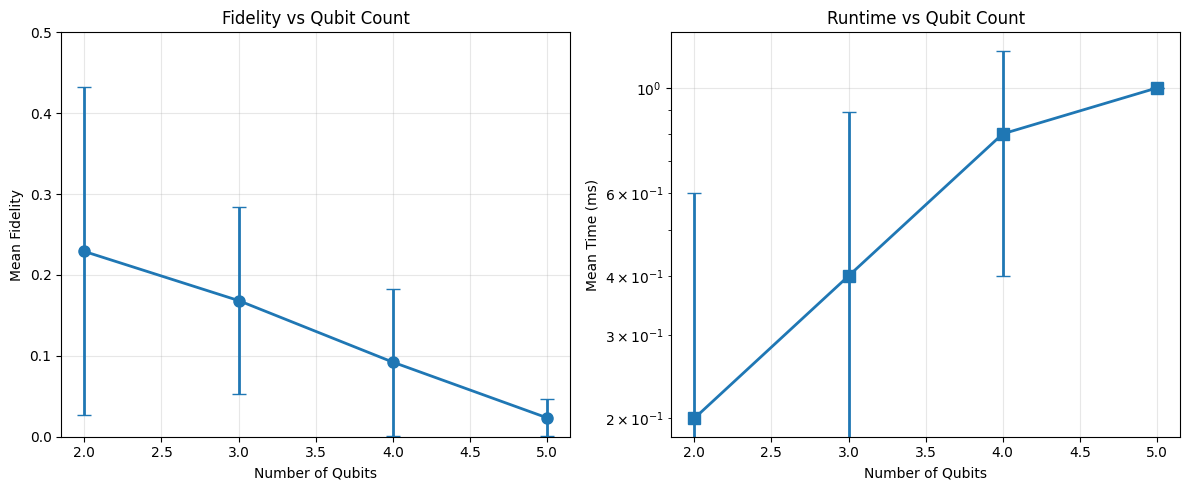

SCALING ANALYSIS
Runtime growth: 5.0x from 2→5 qubits
Fidelity drop:  0.229 -> 0.023

Scaling breaks at ~4 qubits: runtime explodes due to O(4^n) matrix operations


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_scalability(csv_path='scalability_results.csv'):
    """Load CSV and render fidelity/runtime plots with error bars."""
    df = pd.read_csv(csv_path)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: Mean Fidelity with error bars
    ax1.errorbar(df['n_qubits'], df['mean_fidelity'], 
                yerr=df['std_fidelity'], fmt='o-', capsize=5, linewidth=2, markersize=8)
    ax1.set_xlabel('Number of Qubits')
    ax1.set_ylabel('Mean Fidelity')
    ax1.set_title('Fidelity vs Qubit Count')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 0.5)
    
    # Plot 2: Runtime (log scale) with error bars
    ax2.errorbar(df['n_qubits'], df['mean_time_ms'], 
                yerr=df['std_time_ms'], fmt='s-', capsize=5, linewidth=2, markersize=8)
    ax2.set_xlabel('Number of Qubits')
    ax2.set_ylabel('Mean Time (ms)')
    ax2.set_title('Runtime vs Qubit Count')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('scalability_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print key insights
    print("SCALING ANALYSIS")
    print("="*50)
    print(f"Runtime growth: {df['mean_time_ms'].iloc[-1]/df['mean_time_ms'].iloc[0]:.1f}x from {df['n_qubits'].iloc[0]}→{df['n_qubits'].iloc[-1]} qubits")
    print(f"Fidelity drop:  {df['mean_fidelity'].iloc[0]:.3f} -> {df['mean_fidelity'].iloc[-1]:.3f}")
    print("\nScaling breaks at ~4 qubits: runtime explodes due to O(4^n) matrix operations")

plot_scalability()


## Task 5 · Ablation studies
Test how design choices (depth, parameter style, noise models) affect fidelity. Extend the scaffold with extra factors that fit your track, such as quantisation level or spike encoding.

**Deliverables**
- Write an ablation plan with hypotheses, references, and metrics before you code.
- Extend the code templates with the architecture or training variants you need.
- Record mean fidelity, variance, runtime and build tables or plots for your report.

Running ablation study...
Testing 1 layers...
  full : fid=0.056±0.047, time=0.1±0.3ms
  linear: fid=0.144±0.085, time=0.4±0.5ms
Testing 2 layers...
  full : fid=0.177±0.108, time=0.1±0.3ms
  linear: fid=0.094±0.054, time=0.4±0.5ms
Testing 4 layers...
  full : fid=0.184±0.106, time=0.7±0.4ms
  linear: fid=0.102±0.088, time=0.6±0.5ms

ABLATION STUDY RESULTS (3 qubits)

MEAN FIDELITY:
entanglement   full  linear
n_layers                   
1             0.056   0.144
2             0.177   0.094
4             0.184   0.102


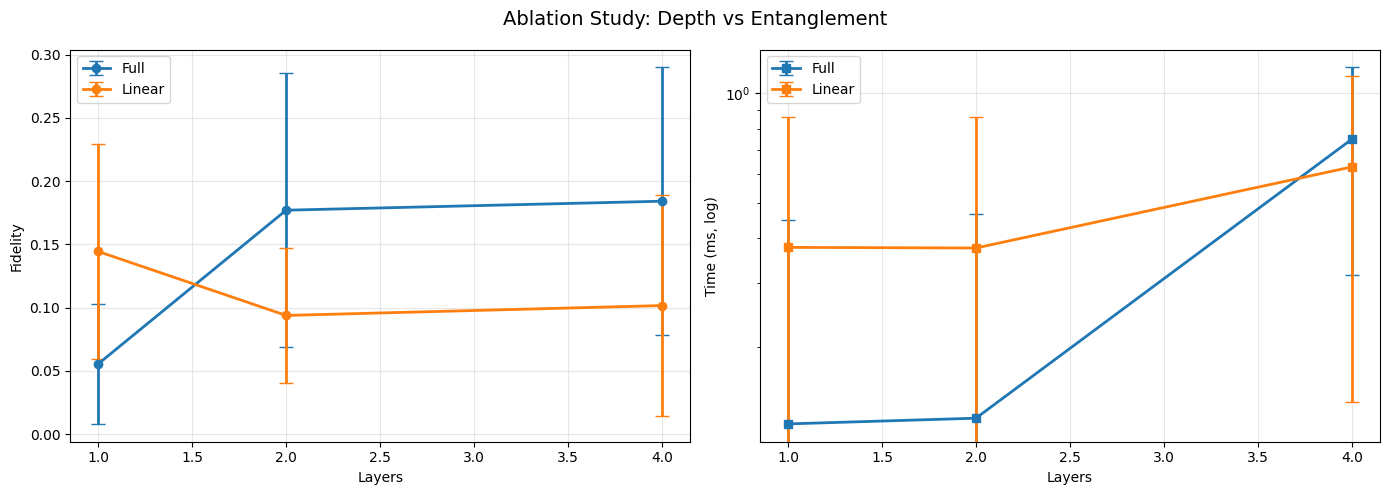


 Ablation complete! Check ablation_results.png


In [10]:
import pandas as pd
import numpy as np
import time
import pickle
from pathlib import Path
import matplotlib.pyplot as plt

def save_pickle(obj, path):
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, 'wb') as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_pickle(path):
    path = Path(path)
    with open(path, 'rb') as f:
        return pickle.load(f)

class QuantumModel:
    def param_count(self):
        return len(self.theta)
    
    def __init__(self, n_qubits, n_layers=1, params=None, seed=None, entanglement='full'):
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.entanglement = entanglement
        self.dim = 2 ** n_qubits
        
        if entanglement == 'full':
            param_size = n_layers * (3 * n_qubits + n_qubits * (n_qubits - 1) // 2)
        else:  # linear
            param_size = n_layers * (3 * n_qubits + n_qubits)
        
        if seed is not None:
            np.random.seed(seed % (2**32 - 1))
        
        if params is not None:
            assert len(params) == param_size
            self.theta = np.array(params, dtype=np.float64)
        else:
            self.theta = np.random.uniform(0, 2*np.pi, param_size)
    
    def statevector(self):
        psi = np.zeros(self.dim, dtype=complex)
        psi[0] = 1.0
        param_idx = 0
        
        for layer in range(self.n_layers):
            for q in range(self.n_qubits):
                rx = self.theta[param_idx]; param_idx += 1
                rz = self.theta[param_idx]; param_idx += 1  
                ry = self.theta[param_idx]; param_idx += 1
                rot = self._single_qubit_rotation(rx, rz, ry)
                psi = self._apply_single_qubit(rot, q, psi)
            
            if self.entanglement == 'full':
                for q1 in range(self.n_qubits):
                    for q2 in range(q1+1, self.n_qubits):
                        phase = self.theta[param_idx]; param_idx += 1
                        psi = self._cphase(phase, q1, q2, psi)
            else:  # linear ring
                for q1 in range(self.n_qubits):
                    q2 = (q1 + 1) % self.n_qubits
                    phase = self.theta[param_idx]; param_idx += 1
                    psi = self._cphase(phase, q1, q2, psi)
        return psi / np.linalg.norm(psi)
    
    def _single_qubit_rotation(self, rx, rz, ry):
        c, s = np.cos, np.sin
        Rx = np.array([[c(rx/2), -1j*s(rx/2)], [-1j*s(rx/2), c(rx/2)]])
        Rz = np.array([[np.exp(-1j*rz/2), 0], [0, np.exp(1j*rz/2)]])
        Ry = np.array([[c(ry/2), -s(ry/2)], [s(ry/2), c(ry/2)]])
        return Rz @ Ry @ Rx
    
    def _apply_single_qubit(self, U, qubit, psi):
        U_full = 1
        for q in range(self.n_qubits):
            if q == qubit:
                U_full = np.kron(U_full, U)
            else:
                U_full = np.kron(U_full, np.eye(2))
        return U_full @ psi
    
    def _cphase(self, phase, control, target, psi):
        psi_out = psi.copy()
        ket11_idx = (1 << control) | (1 << target)
        psi_out[ket11_idx] *= np.exp(1j * phase)
        return psi_out
    
    def fidelity_with(self, target_state):
        psi_model = self.statevector()
        overlap = np.dot(psi_model.conj(), target_state)
        return float(np.real(np.abs(overlap)**2))

def random_pure_state(dim, rng):
    state = rng.normal(0, 1, dim) + 1j * rng.normal(0, 1, dim)
    return state / np.linalg.norm(state)

def ablation_layers(n_qubits=3, layer_list=[1,2,4], trials=8, seed=42):
    """Test depth + entanglement ablation - FIXED SEEDING."""
    np.random.seed(seed)
    results = []
    dim = 2**n_qubits
    
    for n_layers in layer_list:
        print(f"Testing {n_layers} layers...")
        
        for ent_type in ['full', 'linear']:
            trial_times, trial_fids = [], []
            
            for trial in range(trials):
                safe_seed = (seed + n_layers*100 + trial*10 + abs(hash(ent_type))) % (2**32 - 1)
                rng = np.random.RandomState(safe_seed)
                target = random_pure_state(dim, rng)
                
                start = time.time()
                model_seed = rng.randint(0, 2**31)  # Safe model seed
                model = QuantumModel(n_qubits, n_layers, entanglement=ent_type, seed=model_seed)
                fid = model.fidelity_with(target)
                elapsed = (time.time() - start) * 1000
                
                trial_times.append(elapsed)
                trial_fids.append(fid)
            
            results.append({
                'n_qubits': n_qubits,
                'n_layers': n_layers,
                'entanglement': ent_type,
                'mean_time_ms': np.mean(trial_times),
                'std_time_ms': np.std(trial_times),
                'mean_fid': np.mean(trial_fids),
                'std_fid': np.std(trial_fids),
                'param_count': model.param_count()
            })
            
            print(f"  {ent_type:5s}: fid={np.mean(trial_fids):.3f}±{np.std(trial_fids):.3f}, "
                  f"time={np.mean(trial_times):.1f}±{np.std(trial_times):.1f}ms")
    
    return results

def summarize_ablation_results(results):
    df = pd.DataFrame(results)
    
    print("\n" + "="*60)
    print("ABLATION STUDY RESULTS (3 qubits)")
    print("="*60)
    pivot_fid = df.pivot(index='n_layers', columns='entanglement', values='mean_fid')
    print("\nMEAN FIDELITY:")
    print(pivot_fid.round(3))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    for ent in ['full', 'linear']:
        subset = df[df['entanglement'] == ent]
        ax1.errorbar(subset['n_layers'], subset['mean_fid'], subset['std_fid'], 
                    fmt='o-', capsize=5, linewidth=2, label=ent.capitalize())
        ax2.errorbar(subset['n_layers'], subset['mean_time_ms'], subset['std_time_ms'], 
                    fmt='s-', capsize=5, linewidth=2, label=ent.capitalize())
    
    ax1.set_xlabel('Layers'); ax1.set_ylabel('Fidelity'); ax1.legend(); ax1.grid(True, alpha=0.3)
    ax2.set_xlabel('Layers'); ax2.set_ylabel('Time (ms, log)'); ax2.set_yscale('log'); ax2.legend(); ax2.grid(True, alpha=0.3)
    plt.suptitle('Ablation Study: Depth vs Entanglement', fontsize=14)
    plt.tight_layout()
    plt.savefig('ablation_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return df

print("Running ablation study...")
results = ablation_layers(n_qubits=3, layer_list=[1,2,4], trials=8, seed=42)
df = summarize_ablation_results(results)
print("\n Ablation complete! Check ablation_results.png")


## Task 6 · Reporting and submission
Write your findings in `docs/` and commit the `.pkl` checkpoints. Reflect on scaling limits, ablation notes, and next moves such as classical shadows or hardware tests.

### Submission checklist
- `.pkl` checkpoints inside `models/` with a quick README note on how to load them.
- Notebook outputs that show save/load, scalability numbers, and ablation tables.
- Plots that highlight fidelity vs qubits and runtime trends.
- A written summary covering method, limits, and future experiments.